In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

In [2]:
# Mean and std have been calculated in "2. Image Preprocessing in PyTorch"

mean = [0.49159133, 0.48234585, 0.44671956]
std = [0.23819901, 0.23482068, 0.2526521]

In [3]:
train_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


test_transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [4]:
# Loading images in PyTorch dataset
trainset = torchvision.datasets.CIFAR10(root='.datasets/cifar10/train',
                                        train=True,
                                        download= True, 
                                        transform=train_transform)


testset = torchvision.datasets.CIFAR10(root='.datasets/cifar10/train',
                                       train=False,
                                       download= True, 
                                       transform=test_transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=16, 
                                          shuffle=True,
                                          num_workers=2)

testloader = torch.utils.data.DataLoader(testset, 
                                         batch_size=16, 
                                         shuffle=False,
                                         num_workers=2)

In [6]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [7]:
# Let's have a look at one batch of images
img, label = iter(trainloader).next()
img.shape

torch.Size([16, 3, 32, 32])

In [8]:
label

tensor([7, 1, 6, 3, 5, 5, 8, 4, 4, 1, 4, 6, 2, 1, 4, 4])

### Setting up CNN

In [9]:
in_size = 3 # the number of channels in the input image

hid1_size = 16 # we will have 2 convolutional layers
hid2_size = 32

out1_size = 400 # we will have 2 linear layers
out2_size = 10

k_conv_size = 5 # size of kernel 5*5

In [10]:
class ConvNet(nn.Module):
    
    def __init__(self):
        
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_size, hid1_size, k_conv_size),    # output size: 28*28
            nn.BatchNorm2d(hid1_size),                 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))                   # output size: 14*14
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(hid1_size, hid2_size, k_conv_size),  # output size: 10*10
            nn.BatchNorm2d(hid2_size),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))                   # output size: 5*5
        
        self.layer3 = nn.Sequential(
            nn.Linear(hid2_size * k_conv_size * k_conv_size, out1_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(out1_size, out2_size))
        
        
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.layer3(out)
        
        return F.log_softmax(out, dim=-1)

### Training the CNN

In [11]:
model = ConvNet() # creating instance of the model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [12]:
model.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Linear(in_features=800, out_features=400, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=400, out_features=10, bias=True)
  )
)

In [13]:
learning_rate = 0.0005
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), 
                       lr = learning_rate)

In [14]:
total_step = len(trainloader)
num_epochs = 15

In [15]:
loss_values = list()

for epoch in range(num_epochs):
    
    for i, (images, labels) in enumerate(trainloader):
        
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()   
        optimizer.step()
        
        if (i+1)%3000==0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.
                 format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
            loss_values.append(loss.item())
            
print('Finished Training')

Epoch [1/15], Step [3000/3125], Loss: 1.5703
Epoch [2/15], Step [3000/3125], Loss: 0.7970
Epoch [3/15], Step [3000/3125], Loss: 1.3812
Epoch [4/15], Step [3000/3125], Loss: 1.2825
Epoch [5/15], Step [3000/3125], Loss: 0.7295
Epoch [6/15], Step [3000/3125], Loss: 1.0020
Epoch [7/15], Step [3000/3125], Loss: 0.9729
Epoch [8/15], Step [3000/3125], Loss: 0.8256
Epoch [9/15], Step [3000/3125], Loss: 0.7601
Epoch [10/15], Step [3000/3125], Loss: 0.9721
Epoch [11/15], Step [3000/3125], Loss: 0.6415
Epoch [12/15], Step [3000/3125], Loss: 0.7700
Epoch [13/15], Step [3000/3125], Loss: 0.7804
Epoch [14/15], Step [3000/3125], Loss: 0.6279
Epoch [15/15], Step [3000/3125], Loss: 0.7386
Finished Training


Text(0, 0.5, 'Loss')

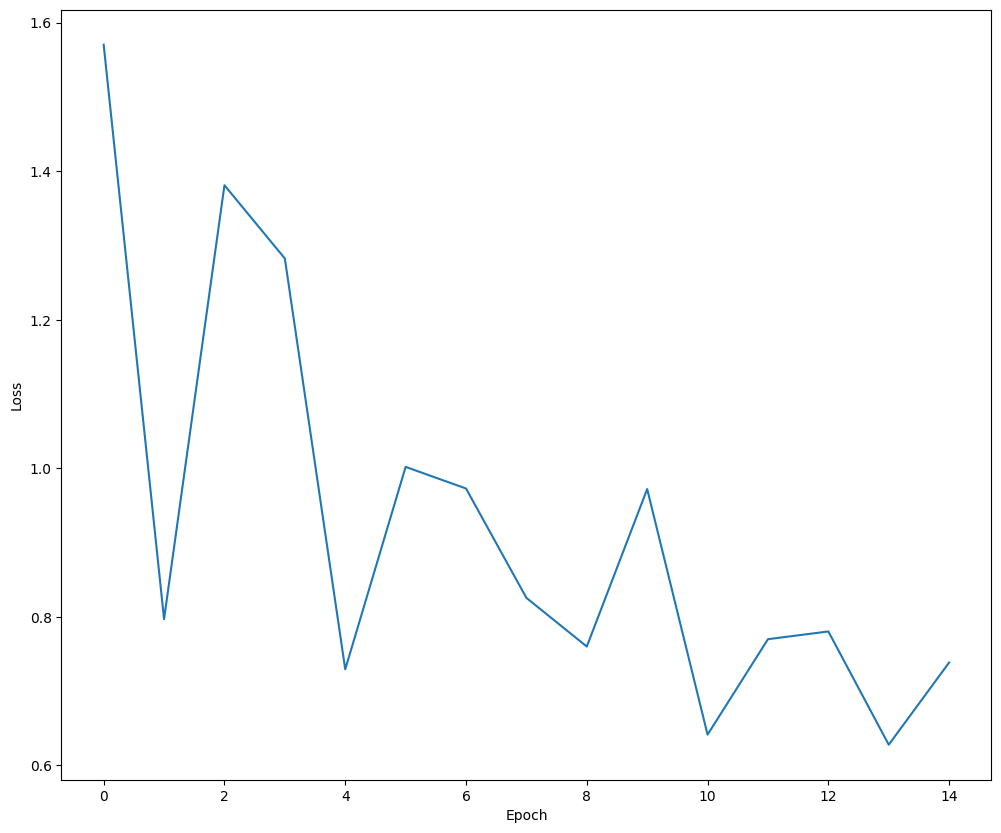

In [16]:
# Visualizing the Loss Values for the training epochs
x = (range(num_epochs))
plt.figure(figsize= (12, 10))
plt.plot(x, loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')

### Using Model on Test Sataset (Making Predictions)

In [17]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += label.size(0)
        correct += (predicted==labels).sum().item()

    print('Accuracy of the model on 10000 test images: {}%'\
          .format(100*correct/total))

Accuracy of the model on 10000 test images: 74.95%


In [18]:
# Having a look at a sample of predictions

sample_img, _ = testset[23]
sample_img.shape

torch.Size([3, 32, 32])

In [19]:
sample_img = np.transpose(sample_img, (1,2,0))

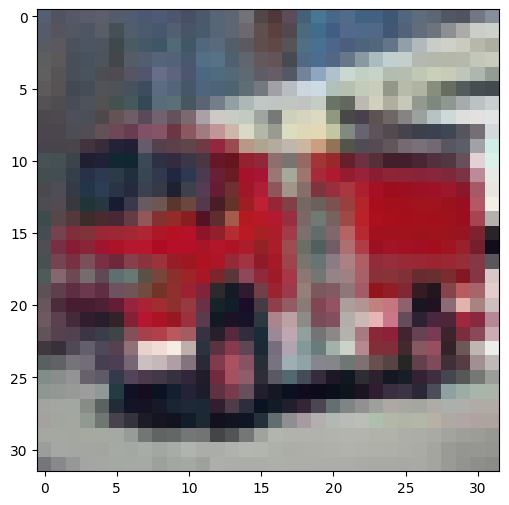

In [20]:
m, M = img.min(), img.max()
sample_img = (1/(abs(m)*M)) * sample_img + 0.5

plt.figure(figsize= (6, 6))
plt.imshow(sample_img)

In [21]:
test_img, test_label = testset[23]
test_img = test_img.reshape(-1, 3, 32, 32)

print("Actual label: ", test_label)

out_predict = model(test_img.to(device))
_, predicted = torch.max(out_predict.data, 1)

print("Predicted label: ", predicted.item())

Actual label:  9
Predicted label:  9


In [22]:
print("Class name for {} : {}".format(predicted.item(), class_names[predicted.item()]))

Class name for 9 : truck
